In [3]:
from h5py.h5i import DATASET
from sympy.physics.secondquant import InnerProduct
from tensorflow.python.keras.legacy_tf_layers.core import dense
%load_ext autoreload
%autoreload 2


import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import keras
import numpy as np
from graph import *
from encoder import create_encoder


from data_processing import processer
import tensorflow_gnn as tfgnn
from tensorflow_gnn.keras.layers import GraphUpdate, SimpleConv

from RepresentationLearner import RepresentationLearner
from compute import *
from GNN import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


In [5]:
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [6]:
x_data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [7]:
target_size = 32
representation_dims = 512
projection_units = 128
num_clusters = 28
kn = 5
tune_encoder_during_clustering = False

In [8]:
x_data = x_data.astype('float32')
processer.layers[-1].adapt(x_data)
x_data

array([[[[ 59.,  62.,  63.],
         [ 43.,  46.,  45.],
         [ 50.,  48.,  43.],
         ...,
         [158., 132., 108.],
         [152., 125., 102.],
         [148., 124., 103.]],

        [[ 16.,  20.,  20.],
         [  0.,   0.,   0.],
         [ 18.,   8.,   0.],
         ...,
         [123.,  88.,  55.],
         [119.,  83.,  50.],
         [122.,  87.,  57.]],

        [[ 25.,  24.,  21.],
         [ 16.,   7.,   0.],
         [ 49.,  27.,   8.],
         ...,
         [118.,  84.,  50.],
         [120.,  84.,  50.],
         [109.,  73.,  42.]],

        ...,

        [[208., 170.,  96.],
         [201., 153.,  34.],
         [198., 161.,  26.],
         ...,
         [160., 133.,  70.],
         [ 56.,  31.,   7.],
         [ 53.,  34.,  20.]],

        [[180., 139.,  96.],
         [173., 123.,  42.],
         [186., 144.,  30.],
         ...,
         [184., 148.,  94.],
         [ 97.,  62.,  34.],
         [ 83.,  53.,  34.]],

        [[177., 144., 116.],
       

In [9]:
encoder = create_encoder(representation_dims)
representation_leaner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)



In [10]:
representation_leaner.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=lr_scheduler, weight_decay=0.0001
    ), jit_compile=False
)


In [11]:
history = representation_leaner.fit(
    x=x_data,
    batch_size=512,
    epochs=50
)

Epoch 1/50


I0000 00:00:1747749264.772899   96941 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-05-20 14:54:29.101259: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-20 14:54:29.101381: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-20 14:54:29.101392: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

118/118 ━━━━━━━━━━━━━━━━━━━━ 62s 290ms/step - loss: 155.9490
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 270ms/step - loss: 12.4564
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - loss: 11.6190
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 244ms/step - loss: 11.2777
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 275ms/step - loss: 11.1350
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 279ms/step - loss: 11.0130
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - loss: 10.9188
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 277ms/step - loss: 10.7847
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 279ms/step - loss: 10.7198
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 279ms/step - loss: 10.5968
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 279ms/step - loss: 10.9419
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 277ms/step - loss: 10.6128
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 276ms/step - loss: 10.4285
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 247ms/step - loss: 10.3064
Epoch 15/50

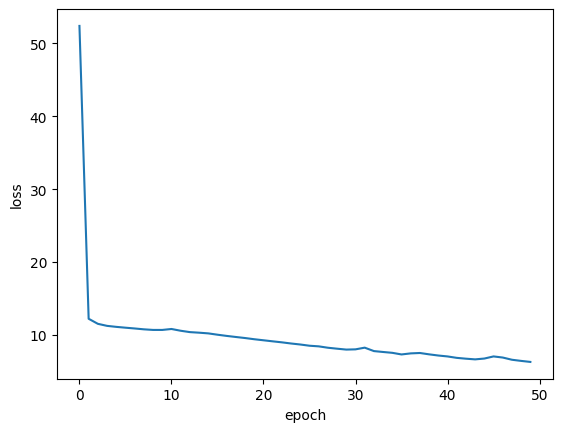

In [12]:
from graph import loss_graph, display_learning_curves

loss_graph(history.history['loss'])

In [127]:

projection = representation_leaner.predict(x_data)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step


In [137]:
from sklearn.neighbors import NearestNeighbors
k = 5
knns = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(projection)
distances, indices = knns.kneighbors(projection)

In [138]:
indices

array([[     0,  70496,  64676,  22804,   4689,  20181],
       [     1,  13337,  91396,  40827,  13369,  17756],
       [     2, 104538,  41997,  82827,  77147,  84016],
       ...,
       [119997,  89127, 106128,  77450,  67751,  15429],
       [119998,   9302,   1940,  40203,  44882,  39384],
       [119999,  83204,  38896,  48296,  99217,  57537]])

In [133]:
projection

array([[0.01447856, 0.2829877 , 0.04519387, ..., 0.69105804, 0.        ,
        0.04005024],
       [0.21771632, 0.27387902, 0.13415672, ..., 0.13187245, 0.06541857,
        0.04522827],
       [0.17537044, 0.28668934, 0.24449176, ..., 0.0842534 , 0.44731054,
        0.46608296],
       ...,
       [0.06623831, 0.06757492, 0.15641783, ..., 0.        , 0.26086757,
        0.19897047],
       [0.16860959, 0.06240962, 0.        , ..., 0.0305047 , 0.12097736,
        0.08266789],
       [0.06713383, 0.02033253, 0.33428746, ..., 0.        , 0.52892196,
        0.07149306]], dtype=float32)

In [155]:
import torch
node_features = torch.tensor(projection, dtype=torch.float)
indices = torch.tensor(indices, dtype=torch.long)


num_nodes, k = indices.shape
sources = np.repeat(np.arange(num_nodes), k)
targets = indices.flatten()

sources = torch.from_numpy(sources)

edge_index = torch.stack([sources, targets], dim=0)

/tmp/ipykernel_96722/3513593915.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices, dtype=torch.long)


In [154]:
edge_index

tensor([[     0,  70496,  64676,  ...,  48296,  99217,  57537],
        [     0,      0,      0,  ..., 119999, 119999, 119999]])

In [142]:
from torch_geometric.data import Data
data = Data(x=node_features, edge_index=edge_index)

In [143]:
data.edge_index

tensor([[     0,      0,      0,  ..., 119999, 119999, 119999],
        [     0,  70496,  64676,  ...,  48296,  99217,  57537]])

In [144]:
num_nodes = data.num_nodes

train_ratio, val_ratio = 0.8, 0.1
nun_train = int(num_nodes * train_ratio)
nun_val = int(num_nodes * val_ratio)

perm = torch.randperm(num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[perm[:nun_train]] = True
val_mask[perm[nun_train : nun_train + nun_val]] = True
test_mask[perm[nun_train + nun_val :]] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [145]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(feature_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x



In [146]:
model = GCN(feature_dim=node_features.shape[1], hidden_dim=16, num_classes=num_classes)

In [147]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [148]:
model.train()

GCN(
  (conv1): GCNConv(128, 16)
  (conv2): GCNConv(16, 10)
)

In [149]:
def contrastive_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    similarity_matrix = torch.mm(z1, z2.t()) / temperature
    labels = torch.arange(z1.size(0)).to(z1.device)
    return F.cross_entropy(similarity_matrix, labels)

In [150]:
import grafog.transforms as T

node_aug = T.Compose([
    T.NodeDrop(p=0.2),
    T.NodeFeatureMasking(p=0.15),
])

edge_aug = T.Compose([
    T.EdgeDrop(p=0.1),
])

def augment_graph(data):
    new_data = node_aug(data)
    new_data = edge_aug(new_data)
    return new_data

In [151]:
import torch_geometric.transforms as T
data = T.ToSparseTensor()(data)

In [152]:
for epoch in range(200):
    optimizer.zero_grad()

    data1 = augment_graph(data)
    data2 = augment_graph(data)

    z1 = model(data1)
    z2 = model(data2)

    loss = contrastive_loss(z1, z2)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')




AttributeError: 'NoneType' object has no attribute 'permute'